In [1]:
!source activate python3
!pip3 install xgboost
!source deactivate

     |████████████████████████████████| 127.6MB 106kB/s  eta 0:00:01
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import nltk
nltk.download(['punkt', 'stopwords'])

[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
import os
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from nltk.tokenize import word_tokenize
from string import punctuation
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble
import xgboost

from keras.preprocessing import text, sequence
from keras import layers, models, optimizers

Using TensorFlow backend.


In [5]:
feed_hashtag = pd.read_csv(os.getcwd() + '/Datasets/feed_hashtag_long.csv')
feed_hashtag['createdAt'] = pd.to_datetime(feed_hashtag['createdAt'])
print(feed_hashtag.shape)
feed_hashtag.head(1)

(13535, 15)


,contentId,authorId_content,createdAt,tagIds,text,type,dt,mnth,yr,yr_mnth,hashtagId,authorId_hashtag,hashtag,isActive,isPrimary
0,5eaa8499d9e8980022200604,5ea238633ae1b80048f4f43c,2020-04-30 07:56:09.909,5df3940fb2694d0016bdb721,Balance #Negotiation Power Negotiation requir...,POST,2020-04-30,4,2020,2020-4,5df3940fb2694d0016bdb721,5df38de0b2694d0016bdb71f,starting-out,True,True


In [6]:
feed_hashtag = feed_hashtag[feed_hashtag['isPrimary'] == True]
feed_hashtag = feed_hashtag[~feed_hashtag['text'].isna()]
print("Data Size:", feed_hashtag.shape[0])
print("Unique Content:", feed_hashtag['contentId'].nunique())
print("Unique tags:", feed_hashtag['hashtag'].nunique())

Data Size: 4142
Unique Content: 2523
Unique tags: 11


In [7]:
feed_hashtag['createDate'] = feed_hashtag['createdAt'].dt.date
feed_hashtag.head(1)

,contentId,authorId_content,createdAt,tagIds,text,type,dt,mnth,yr,yr_mnth,hashtagId,authorId_hashtag,hashtag,isActive,isPrimary,createDate
0,5eaa8499d9e8980022200604,5ea238633ae1b80048f4f43c,2020-04-30 07:56:09.909,5df3940fb2694d0016bdb721,Balance #Negotiation Power Negotiation requir...,POST,2020-04-30,4,2020,2020-4,5df3940fb2694d0016bdb721,5df38de0b2694d0016bdb71f,starting-out,True,True,2020-04-30


In [8]:
feed_hashtag.groupby(['createDate']).agg({'contentId':'nunique', 'tagIds':'count'}).head()

,contentId,tagIds
createDate,,
2019-12-12,261,262
2019-12-14,125,133
2019-12-15,2,2
2019-12-16,15,24
2019-12-17,4,8


In [9]:
feed_hashtag = feed_hashtag.sort_values(['contentId'])

In [10]:
feed_hashtag.groupby(['contentId'])['hashtag'].count().reset_index().sort_values(['hashtag'], ascending = False).head()

,contentId,hashtag
1923,5ea903a51081fc002f901eaf,5
2435,5ebe2fa99acd57002817fefe,4
2403,5ebd02339acd57002817faf5,4
2212,5eb697fcbb6731002ababcac,4
2278,5eb95da7be2b9900460549e1,4


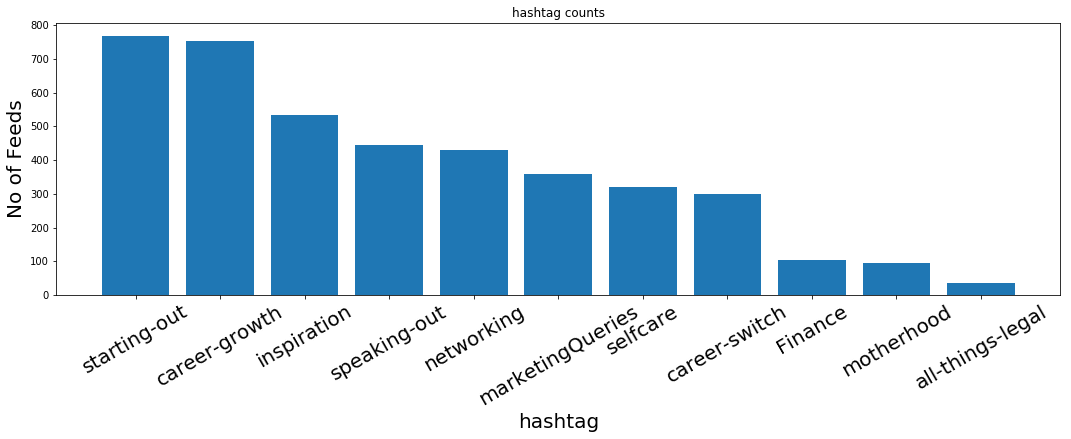

In [11]:
hashtag_class_ct = feed_hashtag.groupby(['hashtag'])['contentId'].agg([('row_count','count'), ('content_count','nunique')]).reset_index()
hashtag_class_ct = hashtag_class_ct.sort_values(['content_count'], ascending=False)
hashtag_class_ct
f, ax = plt.subplots(figsize=(18,5))
plt.bar(hashtag_class_ct['hashtag'], hashtag_class_ct['content_count'])
plt.xlabel('hashtag', fontsize=20)
plt.ylabel('No of Feeds', fontsize=20)
plt.xticks(hashtag_class_ct['hashtag'], fontsize=20, rotation=30)
plt.title('hashtag counts')
plt.show()

In [12]:
feed_hashtag_rollup = feed_hashtag.groupby(['contentId', 'authorId_content', 'createdAt', 'text', 'type', 'isActive', 'isPrimary'])['hashtag'].agg([('hashtag_count','count'), ('hashtag_list', ','.join)]).reset_index()
print(feed_hashtag_rollup.shape)
feed_hashtag_rollup.sort_values(['hashtag_count'],ascending=False).head(2)

(2523, 9)


,contentId,authorId_content,createdAt,text,type,isActive,isPrimary,hashtag_count,hashtag_list
1923,5ea903a51081fc002f901eaf,5ea90095cc13d50046a192fe,2020-04-29 04:33:41.016,"Hi, I am teaching spanish language, If anyone ...",POST,True,True,5,"career-switch,inspiration,selfcare,starting-ou..."
2435,5ebe2fa99acd57002817fefe,5df76af011788b0016813414,2020-05-15 05:59:05.035,We are all fearing the future in some way or t...,QUESTION,True,True,4,"speaking-out,inspiration,selfcare,starting-out"


In [14]:
train = feed_hashtag[feed_hashtag['createdAt'] <= pd.to_datetime('2020-04-30')].copy()
print("train data:", train.shape[0])
test = feed_hashtag[feed_hashtag['createdAt'] > pd.to_datetime('2020-04-30')].copy()
print("test data:", test.shape[0])

train data: 3156
test data: 986


# Text Cleansing

In [15]:
feed_token = [word_tokenize(sent.lower()) for sent in train.text]

In [16]:
stop_punct = list(punctuation)
stop_nltk = stopwords.words("english")
stop_updated = stop_nltk + stop_punct

In [17]:
def del_stop(sent):
    return [term for term in sent if term not in stop_updated]

In [18]:
feed_token_clean = [del_stop(sent) for sent in feed_token]

In [19]:
porter = PorterStemmer()
def stem_tokens(token_list):
    token_stem = [porter.stem(term) for term in token_list]
    return(token_stem)

In [20]:
feed_token_stemmed = [stem_tokens(tk) for tk in feed_token_clean]

In [21]:
train['text_clean'] = [" ".join(sent) for sent in feed_token_clean]
train.head(1)

,contentId,authorId_content,createdAt,tagIds,text,type,dt,mnth,yr,yr_mnth,hashtagId,authorId_hashtag,hashtag,isActive,isPrimary,createDate,text_clean
2272,5df454f37e4ea600161b8e2e,5df454297e4ea600161b8e25,2019-12-14 03:20:19.029,5df39412b2694d0016bdb72b,Hi I am Shreshtha. I have been baking for the ...,QUESTION,2019-12-14,12,2019,2019-12,5df39412b2694d0016bdb72b,5df38de0b2694d0016bdb71f,career-growth,True,True,2019-12-14,hi shreshtha baking last 5 years brand associa...


In [22]:
train_df, validation = model_selection.train_test_split(train)
print(train_df.shape)
print(validation.shape)

(2367, 17)
(789, 17)


In [23]:
validation_rollup = validation.groupby(['contentId', 'authorId_content', 'createdAt', 'text', 'type', 'isActive', 'isPrimary', 'text_clean'])['hashtag'].agg([('hashtag_count','count'), ('hashtag_list', ','.join)]).reset_index()
print(validation_rollup.shape)
validation_rollup.sort_values(['hashtag_count'],ascending=False).head(2)

(700, 10)


,contentId,authorId_content,createdAt,text,type,isActive,isPrimary,text_clean,hashtag_count,hashtag_list
128,5e05e66554f7880016b75c1e,5e058aec54f7880016b75a1d,2019-12-27 11:09:25.269,Wether the work that im doing today would help...,POST,True,True,wether work im today would help build career w...,3,"inspiration,career-switch,starting-out"
602,5ea29bf151316b003f3873f1,5e7c79d8ad47950024ffd1db,2020-04-24 07:57:37.920,"Day 23 April, Time 7.30 A call received to my ...",POST,True,True,day 23 april time 7.30 call received husband `...,3,"starting-out,speaking-out,inspiration"


In [24]:
train_x = train_df['text_clean']
train_y = train_df['hashtag']
valid_x = validation_rollup['text_clean']
valid_y = validation_rollup['hashtag_list']

In [25]:
# label encode the target variable 
encoder = preprocessing.LabelEncoder()
train_y_enc = encoder.fit_transform(train_y)

In [26]:
mapping = pd.DataFrame({'hashtag':train_y, 'hashtag_encoding':train_y_enc})
mapping = mapping.drop_duplicates()
mapping.sort_values(['hashtag_encoding'])

,hashtag,hashtag_encoding
4296,Finance,0
9906,all-things-legal,1
5714,career-growth,2
9411,career-switch,3
12534,inspiration,4
10026,marketingQueries,5
11590,motherhood,6
11718,networking,7
12388,selfcare,8
10246,speaking-out,9


# Count Vectorizer as Features

In [27]:
# create a count vectorizer object 
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(train['text_clean'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='\\w{1,}', tokenizer=None,
                vocabulary=None)

In [28]:
# transform the training and validation data using count vectorizer object
xtrain_count =  count_vect.transform(train_x)
xvalid_count =  count_vect.transform(valid_x)

# Word Level TFIDF Vectors as Features

In [29]:
# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(train['text_clean'])
xtrain_tfidf =  tfidf_vect.transform(train_x)
xvalid_tfidf =  tfidf_vect.transform(valid_x)

# N-gram Level TFIDF

In [ ]:
# ngram level tf-idf 
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram.fit(train['text_clean'])
xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(train_x)
xvalid_tfidf_ngram =  tfidf_vect_ngram.transform(valid_x)

# Character Level TFIDF

In [42]:
# characters level tf-idf
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram_chars.fit(train['text_clean'])
xtrain_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(train_x) 
xvalid_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(valid_x) 

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:524: UserWarning: The parameter 'token_pattern' will not be used since 'analyzer' != 'word'
  warnings.warn("The parameter 'token_pattern' will not be used"


# Model Building

In [30]:
xtrain_var = xtrain_tfidf
xvalid_var = xvalid_tfidf

### Naive Bayes

In [57]:
classifier = naive_bayes.MultinomialNB()
classifier.fit(xtrain_var, train_y_enc)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

### SVM

In [43]:
classifier = svm.SVC(probability=True)
classifier.fit(xtrain_var, train_y_enc)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

### Random Forest

In [69]:
classifier = ensemble.RandomForestClassifier()
classifier.fit(xtrain_var, train_y_enc)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

### XGBoost

In [81]:
classifier = xgboost.XGBClassifier()
classifier.fit(xtrain_var, train_y_enc)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

### Shallow Neural Networks

In [92]:
def create_model_architecture(input_size):
    # create input layer 
    input_layer = layers.Input((input_size, ), sparse=True)
    
    # create hidden layer
    hidden_layer = layers.Dense(1000, activation="relu")(input_layer)
    
    # create output layer
    output_layer = layers.Dense(11, activation="softmax")(hidden_layer)

    classifier = models.Model(inputs = input_layer, outputs = output_layer)
    classifier.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy')
    return(classifier)

In [93]:
train_y_onehot_enc = pd.get_dummies(train_y_enc)

In [94]:
classifier = create_model_architecture(xtrain_var.shape[1])
classifier.fit(xtrain_var, train_y_onehot_enc, epochs=5)








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/5





2367/2367 [==============================] - 6s 2ms/step - loss: 0.2848
Epoch 2/5
2367/2367 [==============================] - 5s 2ms/step - loss: 0.2390
Epoch 3/5
2367/2367 [==============================] - 5s 2ms/step - loss: 0.1986
Epoch 4/5
2367/2367 [==============================] - 5s 2ms/step - loss: 0.1681
Epoch 5/5
2367/2367 [==============================] - 5s 2ms/step - loss: 0.1524


In [97]:
prob_predictions = classifier.predict(xvalid_var)
prob_predictions[0]

array([0.01076617, 0.00769388, 0.04932269, 0.01066311, 0.10985273,
       0.05245522, 0.01292596, 0.12018687, 0.06898011, 0.5431429 ,
       0.01401038], dtype=float32)

### Deep Neural Networks - CNN

In [ ]:
def create_cnn():
    # Add an Input Layer
    input_layer = layers.Input((5000,1))

    # Add the convolutional Layer
    conv_layer = layers.Convolution1D(100, 3, activation="relu")(input_layer)

    # Add the pooling Layer
    pooling_layer = layers.GlobalMaxPool1D()(conv_layer)

    # Add the output Layers
    output_layer1 = layers.Dense(50, activation="relu")(pooling_layer)
    output_layer1 = layers.Dropout(0.25)(output_layer1)
    output_layer2 = layers.Dense(11, activation="softmax")(output_layer1)

    # Compile the model
    model = models.Model(inputs=input_layer, outputs=output_layer2)
    model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy')
    
    return model

In [ ]:
classifier = create_cnn()
classifier.fit(xtrain_var, train_y_onehot_enc)

# Prediction for Accuracy

In [ ]:
#predictions = classifier.predict(xvalid_count)

In [96]:
prob_predictions = classifier.predict_proba(xvalid_var)
prob_predictions[0]

AttributeError: 'Model' object has no attribute 'predict_proba'

In [98]:
prob_prediction_df = pd.DataFrame(prob_predictions)
print(prob_prediction_df.shape)
prob_prediction_df['contentId'] = validation_rollup['contentId']
prob_prediction_df.head()

(700, 11)


,0,1,2,3,4,5,6,7,8,9,10,contentId
0,0.010766,0.007694,0.049323,0.010663,0.109853,0.052455,0.012926,0.120187,0.068980,0.543143,0.014010,5df4556a7e4ea600161b8e32
1,0.004912,0.003344,0.039619,0.420561,0.338132,0.005177,0.007786,0.012904,0.015569,0.059635,0.092363,5df457077e4ea600161b8e53
2,0.013665,0.005795,0.051754,0.016515,0.010483,0.057493,0.004400,0.646000,0.006063,0.006752,0.181080,5df459cf7e4ea600161b8eaa
3,0.003444,0.001670,0.402506,0.012717,0.016926,0.032238,0.004026,0.042816,0.012660,0.043460,0.427539,5df45a507e4ea600161b8eb8
4,0.027111,0.017667,0.089330,0.554980,0.009403,0.051502,0.015449,0.046997,0.007791,0.035277,0.144493,5df45e1d7e4ea600161b8f43


In [99]:
prob_prediction_df_long = pd.melt(prob_prediction_df, id_vars='contentId', value_vars=range(11))
prob_prediction_df_long.columns = ['contentId', 'hashtag_encoding', 'predicted_prob']
prob_prediction_df_long['hashtag_rank'] = prob_prediction_df_long.groupby(['contentId'])['predicted_prob'].rank(ascending=False, method = 'first')
prob_prediction_df_long = prob_prediction_df_long.sort_values(['contentId', 'hashtag_rank'])
prob_prediction_df_long = pd.merge(prob_prediction_df_long, mapping, how = 'left', on = 'hashtag_encoding')
prob_prediction_df_long['pred_rank'] = 'pred_rank_' + prob_prediction_df_long['hashtag_rank'].astype(int).map(str)
prob_prediction_df_long = prob_prediction_df_long.sort_values(['contentId', 'hashtag_rank'])
prob_prediction_df_long.head()

,contentId,hashtag_encoding,predicted_prob,hashtag_rank,hashtag,pred_rank
0,5df4556a7e4ea600161b8e32,9,0.543143,1.0,speaking-out,pred_rank_1
1,5df4556a7e4ea600161b8e32,7,0.120187,2.0,networking,pred_rank_2
2,5df4556a7e4ea600161b8e32,4,0.109853,3.0,inspiration,pred_rank_3
3,5df4556a7e4ea600161b8e32,8,0.068980,4.0,selfcare,pred_rank_4
4,5df4556a7e4ea600161b8e32,5,0.052455,5.0,marketingQueries,pred_rank_5


In [100]:
prob_prediction_df_wide = prob_prediction_df_long.pivot_table(index = ['contentId'], columns = 'pred_rank', values = ['hashtag'], aggfunc=lambda x: ''.join(x))
prob_prediction_df_wide = prob_prediction_df_wide.reset_index()
prob_prediction_df_wide.columns = ['%s%s' % (a, '_%s' % b if b else '') for a, b in prob_prediction_df_wide.columns]
print(prob_prediction_df_wide.shape)
prob_prediction_df_wide.head()


(700, 12)


,contentId,hashtag_pred_rank_1,hashtag_pred_rank_10,hashtag_pred_rank_11,hashtag_pred_rank_2,hashtag_pred_rank_3,hashtag_pred_rank_4,hashtag_pred_rank_5,hashtag_pred_rank_6,hashtag_pred_rank_7,hashtag_pred_rank_8,hashtag_pred_rank_9
0,5df4556a7e4ea600161b8e32,speaking-out,career-switch,all-things-legal,networking,inspiration,selfcare,marketingQueries,career-growth,starting-out,motherhood,Finance
1,5df457077e4ea600161b8e53,career-switch,Finance,all-things-legal,inspiration,starting-out,speaking-out,career-growth,selfcare,networking,motherhood,marketingQueries
2,5df459cf7e4ea600161b8eaa,networking,all-things-legal,motherhood,starting-out,marketingQueries,career-growth,career-switch,Finance,inspiration,speaking-out,selfcare
3,5df45a507e4ea600161b8eb8,starting-out,Finance,all-things-legal,career-growth,speaking-out,networking,marketingQueries,inspiration,career-switch,selfcare,motherhood
4,5df45e1d7e4ea600161b8f43,career-switch,inspiration,selfcare,starting-out,career-growth,marketingQueries,networking,speaking-out,Finance,all-things-legal,motherhood


In [101]:
prediction_results = pd.merge(validation_rollup[['contentId', 'text', 'hashtag_list', 'hashtag_count']], prob_prediction_df_wide, how = 'right', on='contentId', sort=False, copy=True)
#prediction_results = prediction_results.drop(['index_col'], axis=1)
print(prediction_results.shape)
prediction_results.head()

(700, 15)


,contentId,text,hashtag_list,hashtag_count,hashtag_pred_rank_1,hashtag_pred_rank_10,hashtag_pred_rank_11,hashtag_pred_rank_2,hashtag_pred_rank_3,hashtag_pred_rank_4,hashtag_pred_rank_5,hashtag_pred_rank_6,hashtag_pred_rank_7,hashtag_pred_rank_8,hashtag_pred_rank_9
0,5df4556a7e4ea600161b8e32,My name is Shreshtha. I have often faced probl...,Finance,1,speaking-out,career-switch,all-things-legal,networking,inspiration,selfcare,marketingQueries,career-growth,starting-out,motherhood,Finance
1,5df457077e4ea600161b8e53,"Hello, my name is Kalyani. I have done my bach...",Finance,1,career-switch,Finance,all-things-legal,inspiration,starting-out,speaking-out,career-growth,selfcare,networking,motherhood,marketingQueries
2,5df459cf7e4ea600161b8eaa,Gaurika here. I am an aspiring freelancer. Bef...,starting-out,1,networking,all-things-legal,motherhood,starting-out,marketingQueries,career-growth,career-switch,Finance,inspiration,speaking-out,selfcare
3,5df45a507e4ea600161b8eb8,My name is Sharmila.I have been a homemaker fo...,career-switch,1,starting-out,Finance,all-things-legal,career-growth,speaking-out,networking,marketingQueries,inspiration,career-switch,selfcare,motherhood
4,5df45e1d7e4ea600161b8f43,I have been at home on a break for the last 3 ...,career-growth,1,career-switch,inspiration,selfcare,starting-out,career-growth,marketingQueries,networking,speaking-out,Finance,all-things-legal,motherhood


In [102]:
print("Exact Match 1st Prediction:", sum(prediction_results['hashtag_list'] == prediction_results['hashtag_pred_rank_1']))
print("Exact Match 2nd Prediction:", sum(prediction_results['hashtag_list'] == prediction_results['hashtag_pred_rank_2']))
print("Exact Match 3rd Prediction:", sum(prediction_results['hashtag_list'] == prediction_results['hashtag_pred_rank_3']))
print("Exact Match 4th Prediction:", sum(prediction_results['hashtag_list'] == prediction_results['hashtag_pred_rank_4']))
print("Exact Match 5th Prediction:", sum(prediction_results['hashtag_list'] == prediction_results['hashtag_pred_rank_5']))


Exact Match 1st Prediction: 126
Exact Match 2nd Prediction: 117
Exact Match 3rd Prediction: 134
Exact Match 4th Prediction: 93
Exact Match 5th Prediction: 45


In [103]:
h_list = prediction_results['hashtag_list'].str.split(',')
h_list[0]

['Finance']

In [104]:
top_3_pred = prediction_results[['hashtag_pred_rank_1', 'hashtag_pred_rank_2', 'hashtag_pred_rank_3']].values.tolist()
top_3_pred[0]

['speaking-out', 'networking', 'inspiration']

In [105]:
prediction_results['matching_hashtag_ct'] = [len(set(a) & set(b)) for a,b in zip(h_list, top_3_pred)]
prediction_results['matching_percent'] = (prediction_results['matching_hashtag_ct']/prediction_results['hashtag_count'])*100
prediction_results.head(2)

,contentId,text,hashtag_list,hashtag_count,hashtag_pred_rank_1,hashtag_pred_rank_10,hashtag_pred_rank_11,hashtag_pred_rank_2,hashtag_pred_rank_3,hashtag_pred_rank_4,hashtag_pred_rank_5,hashtag_pred_rank_6,hashtag_pred_rank_7,hashtag_pred_rank_8,hashtag_pred_rank_9,matching_hashtag_ct,matching_percent
0,5df4556a7e4ea600161b8e32,My name is Shreshtha. I have often faced probl...,Finance,1,speaking-out,career-switch,all-things-legal,networking,inspiration,selfcare,marketingQueries,career-growth,starting-out,motherhood,Finance,0,0.0
1,5df457077e4ea600161b8e53,"Hello, my name is Kalyani. I have done my bach...",Finance,1,career-switch,Finance,all-things-legal,inspiration,starting-out,speaking-out,career-growth,selfcare,networking,motherhood,marketingQueries,0,0.0


In [106]:
pred_summary = prediction_results.groupby(['matching_percent'])['contentId'].count().reset_index()
pred_summary['content_proportion'] = (pred_summary['contentId']/sum(pred_summary['contentId']))*100
pred_summary.sort_values(['matching_percent'], ascending=False)

,matching_percent,contentId,content_proportion
3,100.000000,398,56.857143
2,66.666667,4,0.571429
1,50.000000,49,7.000000
0,0.000000,249,35.571429


In [107]:
pred_summary = prediction_results.groupby(['matching_percent', 'hashtag_count'])['contentId'].count().reset_index()
pred_summary.sort_values(['hashtag_count', 'matching_percent'], ascending=False)

,matching_percent,hashtag_count,contentId
6,100.000000,3,1
3,66.666667,3,4
5,100.000000,2,20
2,50.000000,2,49
1,0.000000,2,10
4,100.000000,1,377
0,0.000000,1,239
